# Customized Product Proposal - Recommender System

--------------------------------------------------------

@author: jl-datascientist (Jérémy Lecourt)

Objectif:
Système avancé de recommandation de produits afin d'effectuer des propositions personnalisées selon les profils des clients.

Cadre du projet:
Application pour élaborer une proposition personnalisée de Films adaptée selon les profils des individus, en utilisant un jeux de données obtenus depuis le site Imdb.com, plus grand recueil de films/notations utilisateurs sur la toile.

--------------------------------------------------------

## ETAPE 2 : Visualisation des données

### 0 - Import datasets (prepared data from Step 1)

In [1]:
# 2-Data Visualisation and sophisticated analysis

import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# 2.0-Collect data from prepared dataset (cleaned and filtered)

data_m = pd.read_csv(r"Save\data_m.csv")
data_r = pd.read_csv(r"Save\data_r.csv")
data_rev = pd.read_csv(r"Save\data_rev.csv", sep=';')

#print(data_m.shape,data_r.shape,data_rev.shape)

### 1 - Visualise ratings distribution

In [2]:
#2.1 Visualise ratings distribution

viz_1 = data_r.copy()
viz_1['rating'] = viz_1['rating']*2

Text(0.5, 0, 'Distribution')

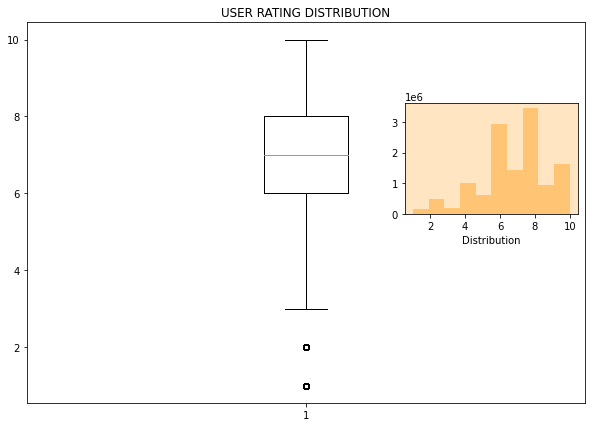

In [3]:
plt.figure(figsize = (10,7))

plt.boxplot(viz_1['rating'])
plt.title( 'USER RATING DISTRIBUTION')
plt.axes([0.65, 0.5, 0.24, 0.22], facecolor='#ffe5c1')
plt.hist(viz_1['rating'], color='#FFC575')
plt.xlabel('Distribution')

Text(0.5, 0, 'Distribution')

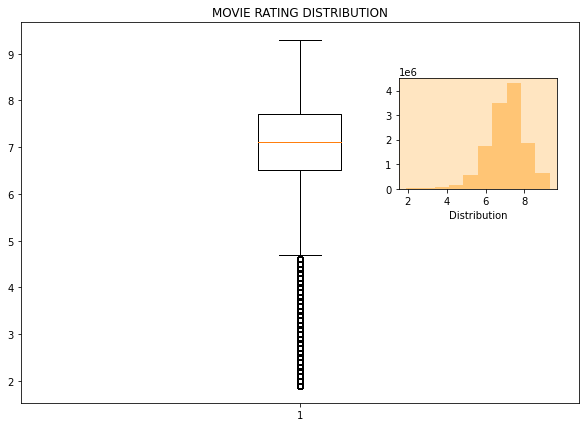

In [4]:
plt.figure(figsize = (10,7))

plt.boxplot(viz_1['averageRating'])
plt.title( 'MOVIE RATING DISTRIBUTION')
plt.axes([0.65, 0.55, 0.22, 0.22], facecolor='#ffe5c1')
plt.hist(viz_1['averageRating'], color='#FFC575')
plt.xlabel('Distribution')

Interprétation visualisation 1 :

On constate que la moyenne des notes par film, et des notes client est autour de 7/10, la distribution des notes moyennes par film est plus stable et plus homogène autour de cette moyenne que la distribution des notes des clients.
Les notes clients sont plus dispersées à travers les quartiles, en revanche il y a plus d'outliers pour les notes moyennes des films.

### 2 - Visualise "genre" dependencies

In [5]:
#2.2 Visualise "Genre" dependencies

# Analysis per genre
genre = data_m["genres_y"].str.split(',',expand=True)
genre_cat = pd.get_dummies(genre,prefix_sep='_')

genre_list = 'Genres : /'
cpt_uniq = 0
cpt_dupl = 0
cpt_total = genre_cat.columns.size
genre_liste = []

for i in list(genre_cat.columns):
    genre_col = i[2:]
    if genre_col not in genre_list :
        genre[genre_col] = genre_cat[i]
        genre_list = genre_list + genre_col + '/'
        cpt_uniq = cpt_uniq + 1
        genre_liste.append(genre_col)
    else :
        genre[genre_col] = genre[genre_col] + genre_cat[i]
        cpt_dupl = cpt_dupl + 1
print(genre_list, cpt_uniq, ' + ', cpt_dupl, ' = ', cpt_total)
        
#genre.head()

Genres : /Action/Adventure/Animation/Biography/Comedy/Crime/Documentary/Drama/Family/Fantasy/History/Horror/Music/Musical/Mystery/Romance/Sci-Fi/Thriller/Western/\N/News/Reality-TV/Sport/War/Short/ 25  +  38  =  63


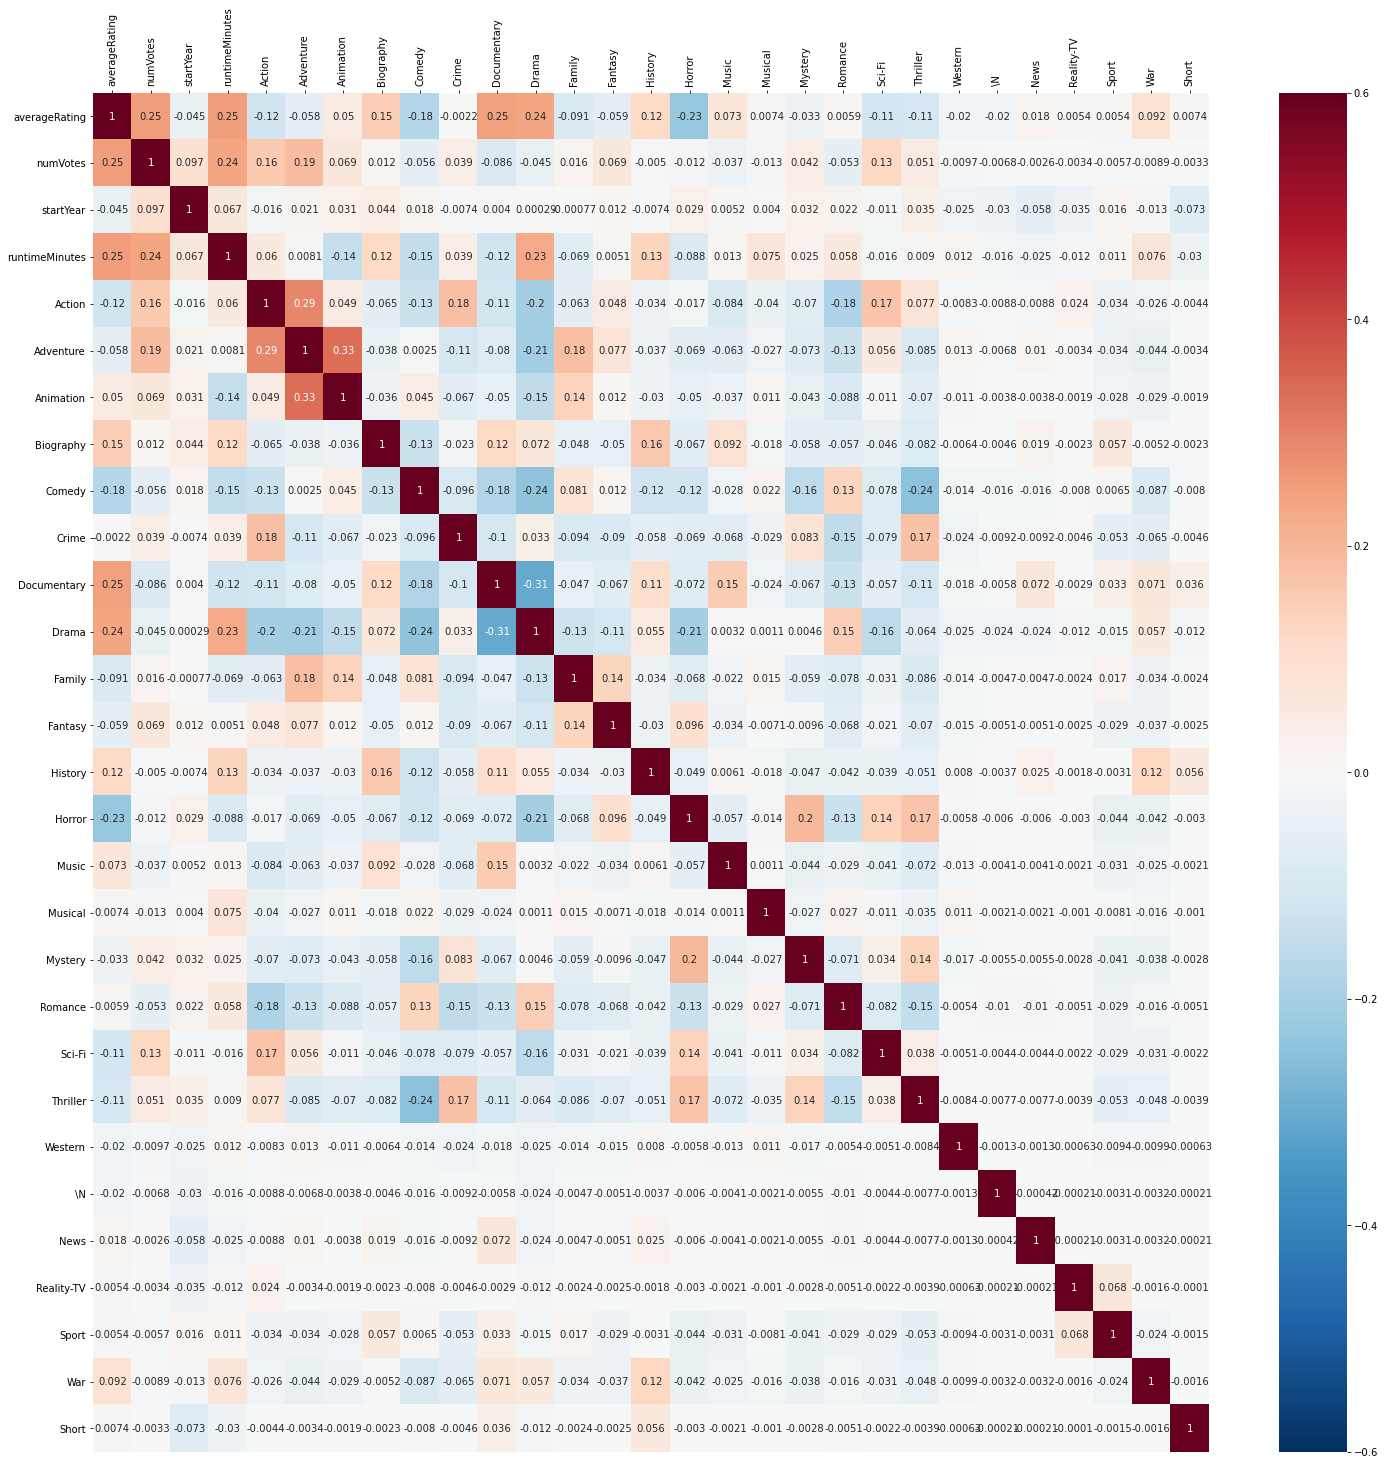

In [6]:
viz_2 = data_m.join(genre)
#to_drop_colv = ['movieId','averageRating','numVotes','startYear','runtimeMinutes']
to_drop_colv = ['movieId']
viz_2 = viz_2.drop(to_drop_colv,axis=1)

viz_2.head()
viz_2.corr()


plt.figure(figsize=(25,25))
ax = plt.gca()
ax = ax.get_xaxis().set_ticks_position('top')

sns.heatmap(viz_2.corr(),  annot=True, cmap="RdBu_r", center =0,vmin=-0.6, vmax=0.6, ax = ax);

Interprétation visualisation 2 :

La heatmap permet de voir quelques corrélations partielles entre le genre des films (par exmple, Aventure/Action/Animation/Famille) ou anticorrélations (par exemple: Drame avec Documentaire/Comedie).
De plus, les genres ayant tendance à avoir indépendemment du Film une corrélation positive avec la notation moyenne du film, sont les documentaires et les drames (corrélation négative pour les films d'horreur et les comédies).

### 3 - Visualise customer behavior

In [7]:
data_r.head()

,movieId,originalTitle,averageRating,numVotes,userId,rating,timestamp,date_rating
0,1,Toy Story,8.3,867989,3,4.0,944919407,1999-12-11 13:36:47
1,1,Toy Story,8.3,867989,6,5.0,858275452,1997-03-13 17:50:52
2,1,Toy Story,8.3,867989,8,4.0,833981871,1996-06-05 13:37:51
3,1,Toy Story,8.3,867989,11,4.5,1230858821,2009-01-02 01:13:41
4,1,Toy Story,8.3,867989,12,4.0,859063718,1997-03-22 20:48:38


In [8]:
#2.3 Visualise customer behavior

#Categorise customers according to registered ratings (nb ratings)

viz_cust0 = data_r.groupby('userId')
print('Average number of ratings per customer:', round(viz_cust0['movieId'].count().mean(),2))

Average number of ratings per customer: 110.03


In [9]:
# Distribution of ratings (customer-oriented point of view)
viz_cust = data_r.groupby('userId')
viz_cust['movieId'].count().describe()

count    116584.000000
mean        110.032612
std         148.415617
min          16.000000
25%          34.000000
50%          60.000000
75%         122.000000
max        3535.000000
Name: movieId, dtype: float64

In [10]:
# Define 4 different categories of customers depending number of votes

viz_3 = pd.DataFrame(columns = ['nbVotes'])
viz_3['nbVotes'] = viz_cust['movieId'].count()
viz_3['catCust'] = pd.qcut(viz_3['nbVotes'], 4, labels = ['c1','c2','c3','c4'])
#viz_3.groupby('catCust')['nbVotes'].describe()

In [13]:
# Visualise customer rating distribution depending its "votes number" category
viz_3r = viz_3.reset_index()
viz_3v = data_r.merge(viz_3r)

{'whiskers': [<matplotlib.lines.Line2D at 0x204ff001f40>,
 'caps': [<matplotlib.lines.Line2D at 0x204ff011640>,
 'boxes': [<matplotlib.lines.Line2D at 0x204ff001be0>],
 'medians': [<matplotlib.lines.Line2D at 0x204ff011d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x204ff01c040>],
 'means': []}

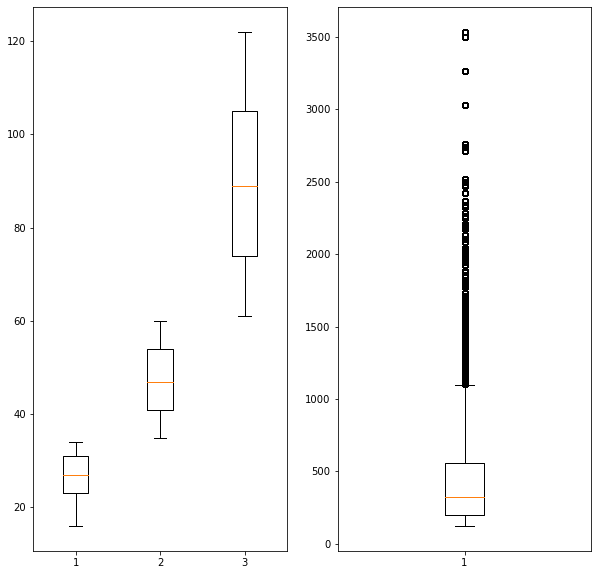

In [14]:
fig = plt.figure(figsize=(10,10))

plt.subplot(121)
plt.boxplot([viz_3v[viz_3v['catCust']=='c1']['nbVotes'], viz_3v[viz_3v['catCust']=='c2']['nbVotes'], viz_3v[viz_3v['catCust']=='c3']['nbVotes']])
plt.subplot(122)            
plt.boxplot([viz_3v[viz_3v['catCust']=='c4']['nbVotes']])


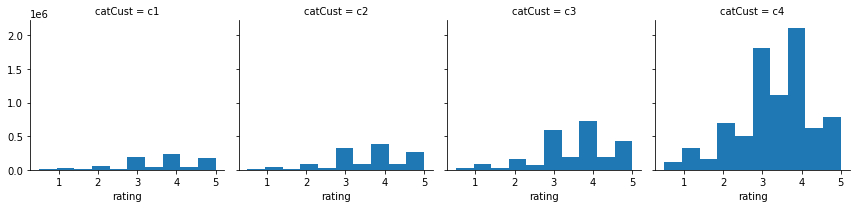

In [15]:
g = sns.FacetGrid(viz_3v, col="catCust")
g.map(plt.hist, "rating")

Interprétation visualisation 3 :

En regroupant les clients selon un critères simple (nbVotes), on se rend compte que la catégorie de client la plus extrême (c4) est assez différente, à la fois en terme d'étendu des quartiles et du nombre d'outliers, mais aussi en terme de distribution des notes.
Pour les autres catégorie de clients (c1/c2/c3), les comportements sont plus homogènes en terme de notation, cependant plus on monte de catégorie, plus on a une tendance à la dispersion des différents quartiles autour de la médiane.

### 4 - Visualise time-related dependencies

In [16]:
#2.4 Visualise time-related dependencies

#Evolution du nombre de ratings clients ces dernières années, et de la moyenne des notes associées
data_r['year'] = data_r['date_rating'].apply(lambda x:x[:4])
data_r.head()


,movieId,originalTitle,averageRating,numVotes,userId,rating,timestamp,date_rating,year
0,1,Toy Story,8.3,867989,3,4.0,944919407,1999-12-11 13:36:47,1999
1,1,Toy Story,8.3,867989,6,5.0,858275452,1997-03-13 17:50:52,1997
2,1,Toy Story,8.3,867989,8,4.0,833981871,1996-06-05 13:37:51,1996
3,1,Toy Story,8.3,867989,11,4.5,1230858821,2009-01-02 01:13:41,2009
4,1,Toy Story,8.3,867989,12,4.0,859063718,1997-03-22 20:48:38,1997


In [17]:
viz_4 = pd.DataFrame(columns = ['nbVotes','avgRatings'])

viz_4['nbVotes'] = data_r.groupby('year')['rating'].count()
viz_4['avgRatings'] = data_r.groupby('year')['rating'].mean()

viz_4 = viz_4.drop(index = '1995')

In [18]:
data_r[data_r['year']=='1995']

,movieId,originalTitle,averageRating,numVotes,userId,rating,timestamp,date_rating,year
1589487,21,Get Shorty,6.9,74730,131160,3.0,789652009,1995-01-09 11:46:49,1995
1648278,47,Se7en,8.6,1408825,131160,5.0,789652009,1995-01-09 11:46:49,1995
11720652,1176,La double vie de Véronique,7.8,40896,28507,4.0,789652004,1995-01-09 11:46:44,1995


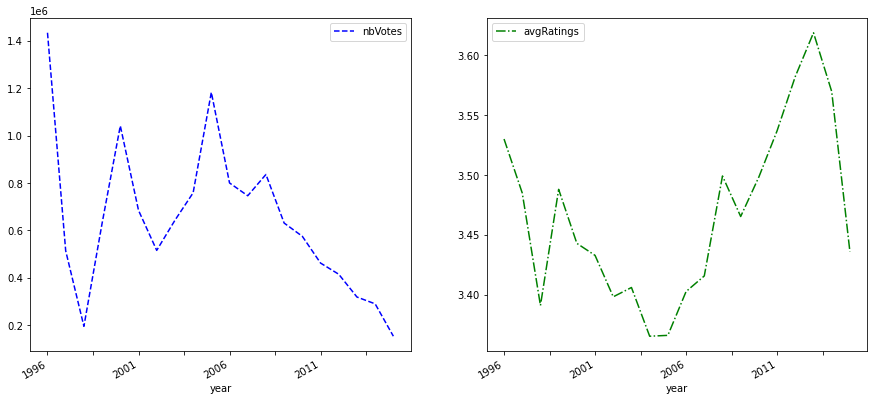

In [19]:
viz_4.plot(y = ['nbVotes', 'avgRatings'], subplots=True, layout= (2,2),
        style = ['b--', 'g-.'], figsize=(15,15));

Interprétation visualisation 4 :
    
L'évolution du nombre de notes semble être instable entre 1995 et 2005 (oscillations entre 200 000 et 1,5 millions de votes par année). Il y a en revanche une tendance assez stable à la baisse depuis 2008.
La note moyenne par année semble osciller à la hausse puis à la baisse autour de la note moyenne de 7/10, avec peu de variance si on tient compte de l'échelle.

### 5 - Visualise reviews evaluation

Text(0.5, 1.0, 'REVIEWS - GLOBAL DISTRIBUTION')

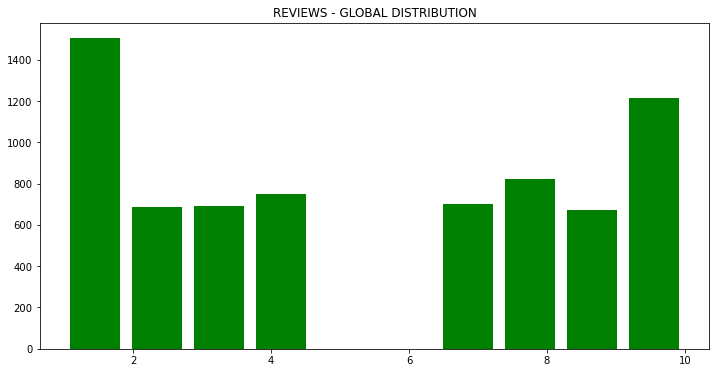

In [20]:
#2.5 Visualise reviews evaluation

viz_genre = viz_2.iloc[:,10:]
viz_genre['imdbId'] = viz_2.iloc[:,0]

fig = plt.figure(figsize=(12,6))
viz_5 = data_rev.merge(viz_genre)

plt.hist(viz_5.ratingReview, color='green', rwidth = 0.8);
plt.title('REVIEWS - GLOBAL DISTRIBUTION')

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Western', '\\N', 'News', 'Reality-TV', 'Sport', 'War', 'Short']


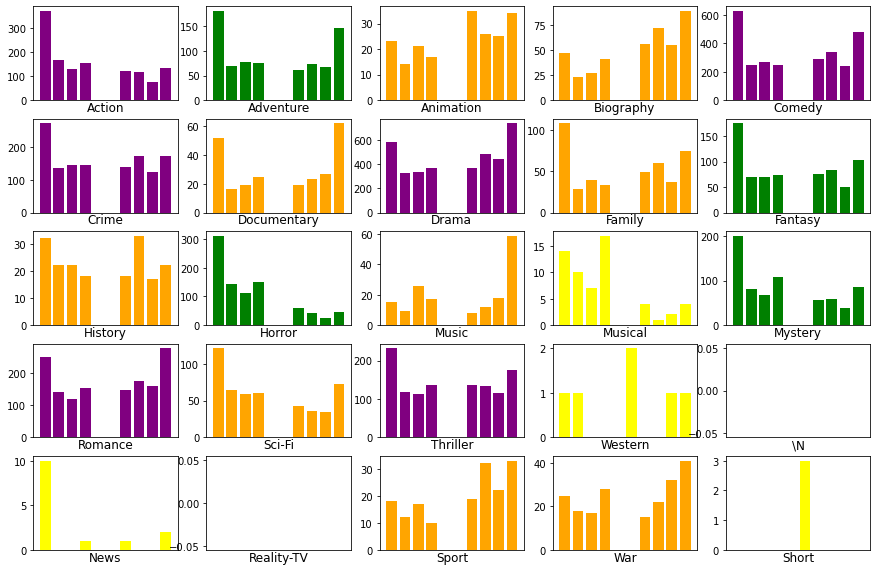

In [21]:
viz_5[viz_5['Action']==1]
print(genre_liste)

fig = plt.figure(figsize=(15,10))

i = 0
for g in list(genre_liste):
    i = i + 1
    plt.subplot(5,5,i)
    cpt = viz_5[viz_5[g]==1]['imdbId'].count()
    if cpt < 100:
        c = 'yellow'
    elif cpt < 500:
        c = 'orange'
    elif cpt < 1000:
        c = 'green'
    else:
        c = 'purple'
    plt.hist(viz_5[viz_5[g]==1].ratingReview, color=c, rwidth = 0.8);
    plt.title(g, y=-0.18)
    plt.xticks([])
#    plt.yticks([])


Interpréatation visualisation 5 :

Cette visualisation permet de se rendre compte de la répartition des notes dans le dataset de "Stanford University" pour l'étude du sentiment analysis sur base des reviews utilisateurs du même site Imdb.com.
On remarque que les reviews ont été choisies en éliminant les notations moyennes (5/10 et 6/10) car le but était de pouvoir déterminer une orientation clairement positive ou négative dans chaque commentaire par rapport à sa note.
On remarque aussi qu'il y a environ 2 fois plus de reviews sur les notes extrêmes (1/10 et 10/10).
Enfin, la même visualisation effectuée par genre de film permet de se rendre compte des genres plus ou moins présents dans ce dataset (couleur d'histogramme d'autant plus foncée) et de la répartition des notes des reviews d'un genre à l'autre.